## Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Malaria Image Classification Project

In [ ]:
from google.colab import files
files.upload() # Upload kaggle.json to Colab

# Create a directory for Kaggle configuration
!mkdir -p ~/.kaggle

# Move kaggle.json to the correct directory
!mv kaggle.json ~/.kaggle/

# Set permissions for kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the Malaria dataset from Kaggle
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

# Unzip and inspect contents
!unzip cell-images-for-detecting-malaria.zip -d ./malaria_data


os.listdir('./malaria_data')

Streaming output truncated to the last 5000 lines.
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127

['cell_images']

## Install Dependencies

In [ ]:
%pip install matplotlib opencv-python tensorflow keras numpy scikit-learn seaborn

## Import and Explore the Data

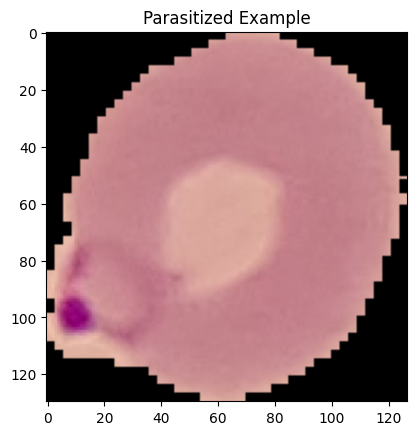

In [ ]:
parasitized = os.listdir('./malaria_data/cell_images/Parasitized')
uninfected = os.listdir('./malaria_data/cell_images/Uninfected')

img = cv2.imread('./malaria_data/cell_images/Parasitized/' + parasitized[0])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Parasitized Example")
plt.show()

In [ ]:
# Create ImageDataGenerator object to automatically preprocess images.
# Normalize pixel values and reserve 20% of data for validation.
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training dataset generator
train = datagen.flow_from_directory('./malaria_data/cell_images/cell_images',
                                    target_size=(128,128),    # Resize all images to 128x128 pixels
                                    batch_size=32,            # Model processes 32 images at a time
                                    class_mode='binary',      # We use binary because there are only two classes: 'Parasitized' and 'Uninfected'
                                    subset='training')        # Uses 80% of images for training

# Create a validation dataset generator
val = datagen.flow_from_directory('./malaria_data/cell_images/cell_images',
                                  target_size=(128,128),
                                  batch_size=32,
                                  class_mode='binary',
                                  subset='validation')        # Use the remaining 20% of images for validation

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 399/1378 ━━━━━━━━━━━━━━━━━━━━ 2:14 137ms/step - accuracy: 0.2445 - loss: -34554736.0000

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9255 - loss: 0.1917
Validation Accuracy: 0.9245
Validation Loss: 0.2105


173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


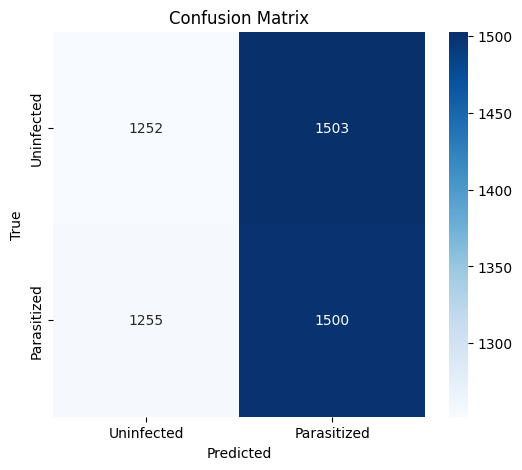

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.50      0.45      0.48      2755
 Parasitized       0.50      0.54      0.52      2755

    accuracy                           0.50      5510
   macro avg       0.50      0.50      0.50      5510
weighted avg       0.50      0.50      0.50      5510



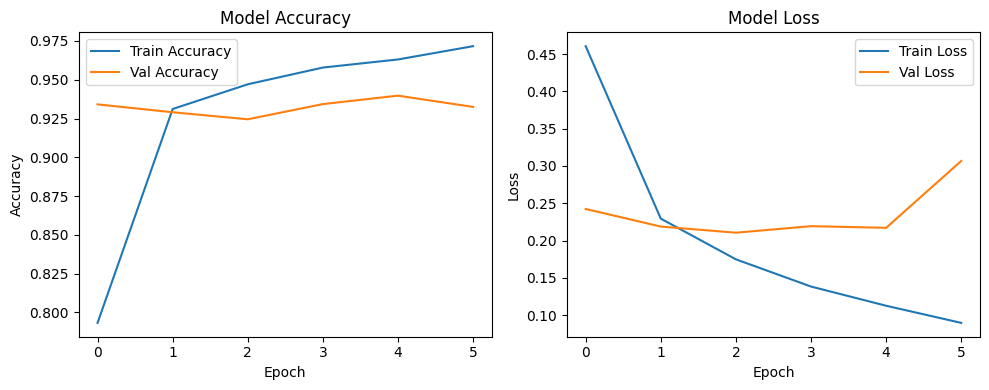

In [ ]:
# Evaluate model on the validation set
val_loss, val_acc = model.evaluate(val)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print("\n")

# Get predicted labels (probabilities → binary 0/1)
y_pred_probs = model.predict(val, steps=len(val))
y_pred = (y_pred_probs > 0.5).astype("int32").ravel()

# True labels from the validation generator
y_true = val.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected','Parasitized'],
            yticklabels=['Uninfected','Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Detailed precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Uninfected','Parasitized']))

# Accuracy plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()